# Setup Data Set

Import yfinance package to call yahoo finance API to fetch daily stock index prices, see documentation for more https://pypi.org/project/yfinance/ .

In [47]:
import yfinance as yf

Fetches price history for a symbol, for our case SNP500 index is used.

In [48]:
snp500 = yf.Ticker("^GSPC")

Query historical prices for maximum time period, ie. all time data.

In [49]:
snp500 = snp500.history(period="max")
snp500


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-03 00:00:00-04:00,5492.740234,5499.529785,5390.830078,5396.520020,7210470000,0.0,0.0
2025-04-04 00:00:00-04:00,5292.140137,5292.140137,5069.899902,5074.080078,8853500000,0.0,0.0
2025-04-07 00:00:00-04:00,4953.790039,5246.569824,4835.040039,5062.250000,8691980000,0.0,0.0


Clean data by removing unnecessary columns.

In [50]:
del snp500['Dividends']
del snp500['Stock Splits']

Plot closing prices for refrence.

<Axes: xlabel='Date'>

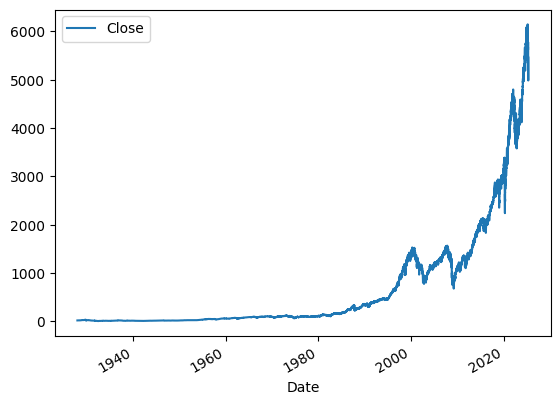

In [51]:
snp500.index
snp500.plot.line(y="Close", use_index=True)

# Setup Target For ML Model

First add a column for the closing price for next day.

In [52]:
snp500["Tommorow"] = snp500["Close"].shift(-1)

Next, add in the the target column, comparing if the price increased or decreased from the previous day. Keep in mind that true will be represented as 1 and false as 0.

In [53]:
snp500["Target"] = (snp500["Tommorow"] > snp500["Close"]).astype(int)

To keep data accurate we will restrict the data to start at 1990.

In [54]:
snp500 = snp500.loc["1990-01-01":].copy()

Below is an updated table for refrence.

In [55]:
snp500

,Open,High,Low,Close,Volume,Tommorow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2025-04-03 00:00:00-04:00,5492.740234,5499.529785,5390.830078,5396.520020,7210470000,5074.080078,0
2025-04-04 00:00:00-04:00,5292.140137,5292.140137,5069.899902,5074.080078,8853500000,5062.250000,0
2025-04-07 00:00:00-04:00,4953.790039,5246.569824,4835.040039,5062.250000,8691980000,4982.770020,0


# Training Initial ML Model

Random forest will train many individual decision trees with randomized sub-samples of the dataset, will help reduce over-fitting.

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Setting 100 individual decision trees to train (n_estimators), will increase in future for better accuracy
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = snp500.iloc[:-100]
test = snp500.iloc[-100:]

# Trains the model using following predictors to predict the target
predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

Below is the precision score of our model, as we can see our model is not very accurate.

In [57]:
from sklearn.metrics import precision_score
import pandas as pd

predictions = model.predict(test[predictors])
predictions = pd.Series(predictions, index=test.index)

precision_score(test["Target"], predictions)

0.5287356321839081

Below we plot the predictions.

<Axes: xlabel='Date'>

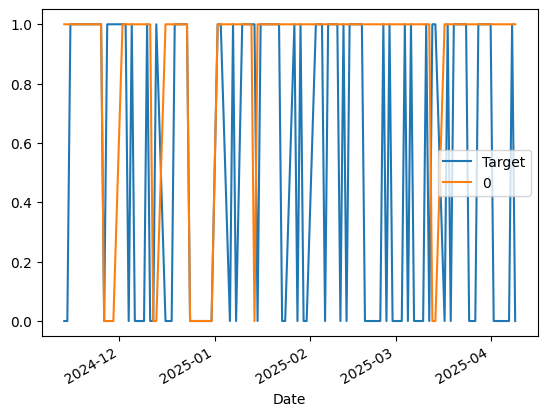

In [58]:
combined = pd.concat([test["Target"], predictions], axis=1)
combined.plot()

# Implement Backtesting System

First, add a predict method to bundle code to fit the model, generate predictions, and combine model into pandas series.

In [59]:
def predict(train, test, predictors, model):

    model.fit(train[predictors], train["Target"])

    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")

    combined = pd.concat([test["Target"], preds], axis=1)
    
    return combined
    

Second implement the backtesting method. We are training first model on 10 years of data (2500) and then going to the next year.

In [60]:
def backtest(data, model, predictors, start=2500, step=250):

    all_preds = []

    for i in range(start, data.shape[0], step):

        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        predictions = predict(train, test, predictors, model)
        all_preds.append(predictions)
    
    return pd.concat(all_preds)


Backtest our model.

In [61]:
predictions = backtest(snp500, model, predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.5287009063444109

# Tweak Model

First we will add some additional predictors

In [62]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = snp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    snp500[ratio_column] = snp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    snp500[trend_column] = snp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

snp500 = snp500.dropna(subset = snp500.columns[snp500.columns != "Tomorrow"])

Improve model by increaing individual decision trees to train (n_estimators).

In [63]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

Improve predict method to use probability. Here we are able to ensure that the model is more confident that the price will go up.

In [64]:
def predict(train, test, predictors, model):

    model.fit(train[predictors], train["Target"])

    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    
    combined = pd.concat([test["Target"], preds], axis=1)

    return combined

Run our backtest on the new model. Note the increase in precision score.

In [65]:
predictions = backtest(snp500, model, new_predictors)
precision_score(predictions["Target"], predictions["Predictions"])

0.570771001150748